# Snake

In [17]:
from snake import re_normalize_possible_actions
from environments import *
import tensorflow as tf
import numpy as np
from  tqdm import trange
import matplotlib.pyplot as plt

## Environment definition

In [18]:
BOARD_SIZE=3

In [19]:
# region models
input = K.layers.Input(shape=(BOARD_SIZE, BOARD_SIZE, 3))
x = K.layers.Conv2D(32, (3, 3), padding="SAME", activation="linear", use_bias=False)(input)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.leaky_relu)(x)

x = K.layers.Conv2D(32, (3, 3), padding="SAME", activation="linear", use_bias=False)(x)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.leaky_relu)(x)

x = K.layers.MaxPool2D(2)(x)

x = K.layers.Conv2D(32, (2, 2), padding="SAME", activation="linear", use_bias=False)(x)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.leaky_relu)(x)

x = K.layers.Conv2D(8, (2, 2), padding="SAME", activation="linear", use_bias=False)(x)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.leaky_relu)(x)
x = K.layers.GlobalAvgPool2D()(x)

policy = K.layers.Dense(64, activation=tf.nn.leaky_relu)(x)
policy = K.layers.Dense(64, activation=tf.nn.leaky_relu)(policy)
policy = K.layers.Dense(4, activation=tf.nn.softmax)(policy)
agent = K.models.Model(inputs=input, outputs=policy)




input = K.layers.Input(shape=(BOARD_SIZE, BOARD_SIZE, 3))
x = K.layers.Conv2D(32, (3, 3), padding="SAME", activation="linear", use_bias=False)(input)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.leaky_relu)(x)

x = K.layers.Conv2D(32, (3, 3), padding="SAME", activation="linear", use_bias=False)(x)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.leaky_relu)(x)

x = K.layers.MaxPool2D(2)(x)

x = K.layers.Conv2D(32, (2, 2), padding="SAME", activation="linear", use_bias=False)(x)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.leaky_relu)(x)

x = K.layers.Conv2D(8, (2, 2), padding="SAME", activation="linear", use_bias=False)(x)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.leaky_relu)(x)
x = K.layers.GlobalAvgPool2D()(x)

vf = K.layers.Dense(64, activation=tf.nn.leaky_relu)(x)
vf = K.layers.Dense(64, activation=tf.nn.leaky_relu)(vf)
vf = K.layers.Dense(1, activation="linear")(vf)
value = K.models.Model(inputs=input, outputs=vf)

In [20]:
#agent.load_weights(f"models/{BOARD_SIZE}x{BOARD_SIZE}_bigger/agent")
#value.load_weights(f"models/{BOARD_SIZE}x{BOARD_SIZE}_bigger/value")

## Training

In [37]:
env_ = NumpyEnvironment(1000, BOARD_SIZE)
GAMMA = .99
ITERATIONS = 500000

In [26]:
agent.load_weights(f"models/{BOARD_SIZE}x{BOARD_SIZE}_bigger/agent")
value.load_weights(f"models/{BOARD_SIZE}x{BOARD_SIZE}_bigger/value")

In [38]:
optimizer_value = K.optimizers.Adam(1e-5)
optimizer_agent = K.optimizers.Adam(1e-5)

In [ ]:
avg_rewards = []
ae_losses = []

In [39]:
for iterations in trange(ITERATIONS):
    state = env_.to_state()

    with tf.GradientTape(persistent=True) as tape:
        # calculate distributions of actions
        original_probs = agent(
            state
        )
        if tf.reduce_any(tf.math.is_nan(original_probs)):
            raise Exception("NaN found")
        # remove actions that are not available
        probs = re_normalize_possible_actions(
            state,
            original_probs
        )
        # sample actions
        actions = tf.random.categorical(tf.math.log(tf.stop_gradient(probs)), 1, dtype=tf.int32)

        # MDP update
        # print("start move")
        rewards = env_.move(actions)
        # print("end move")
        new_state = env_.to_state()

        # TD error
        value_state = value(state)
        td_error = tf.stop_gradient((rewards + GAMMA * value(new_state, training=False)) - value_state) * -1  # to do gradient ascend

        # calculate the loss for both value and agent
        actions_indexes = tf.concat((tf.range(actions.shape[0])[..., None], actions), axis=-1)

        # maybe introduce eligibility trace to simulate n-step td, to have longer dependencies
        loss_agent = tf.stop_gradient(td_error) * tf.math.log(tf.gather_nd(probs, actions_indexes))
        loss_value = tf.stop_gradient(td_error) * value_state

    # calculate gradient
    gradient_agent = tape.gradient(loss_agent, agent.trainable_weights)
    gradient_value = tape.gradient(loss_value, value.trainable_weights)
    avg_rewards.append(tf.reduce_mean(rewards))

    # update neural nets weights
    optimizer_agent.apply_gradients(zip(gradient_agent, agent.trainable_weights))
    optimizer_value.apply_gradients(zip(gradient_value, value.trainable_weights))


    if iterations % 100 == 0:
        agent.save_weights(f"models/{BOARD_SIZE}x{BOARD_SIZE}_bigger/agent")
        value.save_weights(f"models/{BOARD_SIZE}x{BOARD_SIZE}_bigger/value")


  3%|▎         | 15010/500000 [13:27<7:15:05, 18.58it/s]


KeyboardInterrupt: 

### Random policy reward

In [30]:
random_env_ = NumpyEnvironment(1000, BOARD_SIZE)
random_rewards = []

for _ in trange(1000):
    state = random_env_.to_state()
    probs = re_normalize_possible_actions(
        state,
        tf.repeat([[.25]*4],1000, axis=0)
    )
    #sample actions
    actions =  tf.random.categorical(tf.math.log(probs), 1, dtype=tf.int32)

    # MDP update
    rewards = random_env_.move(actions)
    random_rewards.append(tf.reduce_mean(rewards))

100%|██████████| 1000/1000 [00:15<00:00, 63.12it/s]


## Training evaluation

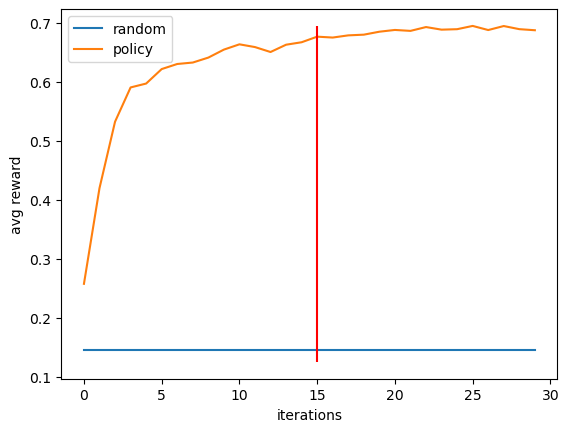

In [46]:
%matplotlib inline
N = 30000
CHUNK_SIZE = 1000
plt.plot(np.arange(N//CHUNK_SIZE), np.array(random_rewards).mean(axis=-1).repeat(N//CHUNK_SIZE))
points = np.array(avg_rewards)[:N].reshape((-1, CHUNK_SIZE)).mean(axis=-1)
plt.plot(points)
plt.vlines(15000//CHUNK_SIZE, min(np.max(points), np.array(random_rewards).mean(axis=-1))-0.02, np.max(points), colors=["red"])
_ = plt.xlabel("iterations")
_ = plt.ylabel("avg reward")
plt.legend(["random", "policy"])

## Test (graphical simulation)

In [47]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [48]:
test_env = NumpyEnvironment(10,BOARD_SIZE)

In [49]:
def animate(_):
    state = test_env.to_state()
    original_probs = agent(
        state
    )
    probs = re_normalize_possible_actions(
        state,
        original_probs
    )
    log_probs = tf.math.log(tf.stop_gradient(probs))
    actions =  tf.random.categorical(log_probs, 1, dtype=tf.int32)
    test_env.move(actions)
    for board, image in zip(test_env.boards, images):
        image.set_data(board)
    return images

In [53]:
fig, axs = plt.subplots(2,5, figsize=(10,5))
images = []
for b, ax in zip(test_env.boards, axs.flatten()):
    images.append(ax.imshow(b, origin="lower"))
anim = FuncAnimation(fig, animate, frames=3,interval=10)

<IPython.core.display.Javascript object>

In [14]:
state = test_env.to_state()
original_probs = agent(
    state
)
probs = re_normalize_possible_actions(
    state,
    original_probs
)
log_probs = tf.math.log(tf.stop_gradient(probs))
actions =  tf.random.categorical(log_probs, 1, dtype=tf.int32)
test_env.move(actions)

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)>

In [16]:
original_probs

<tf.Tensor: shape=(10, 4), dtype=float32, numpy=
array([[nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan]], dtype=float32)>